<a href="https://colab.research.google.com/github/LeoMcBills/100-Days-Of-ML-Code/blob/master/pix2pix_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Play ground colab for my different models

## Pix2Pix GAN

### Import necessary libraries

In [9]:
import tensorflow as tf

from google.colab import drive

import os
import pathlib
import time
import datetime


from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

### List data from drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
root = "/content/drive/MyDrive/Ugandan Dataset/Data"

In [7]:
for folder in os.listdir(root):
  folder_path = os.path.join(root, folder)
  if os.path.isdir(folder_path):
    total_elements = 0
    for subdir, _, files in os.walk(folder_path):
      total_elements += len(files)
    print(f"Folder: {folder}, Total elements (including subfolders): {total_elements}")
  else:
    print(f"  - {folder} (not a directory)")
  print("-" * 60)

Folder: val, Total elements (including subfolders): 504
------------------------------------------------------------
Folder: train, Total elements (including subfolders): 1764
------------------------------------------------------------


### Read paired data

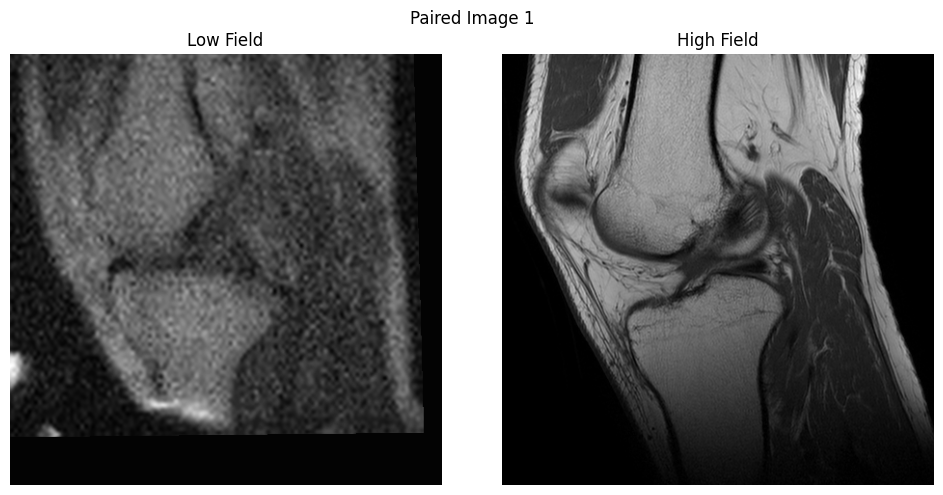

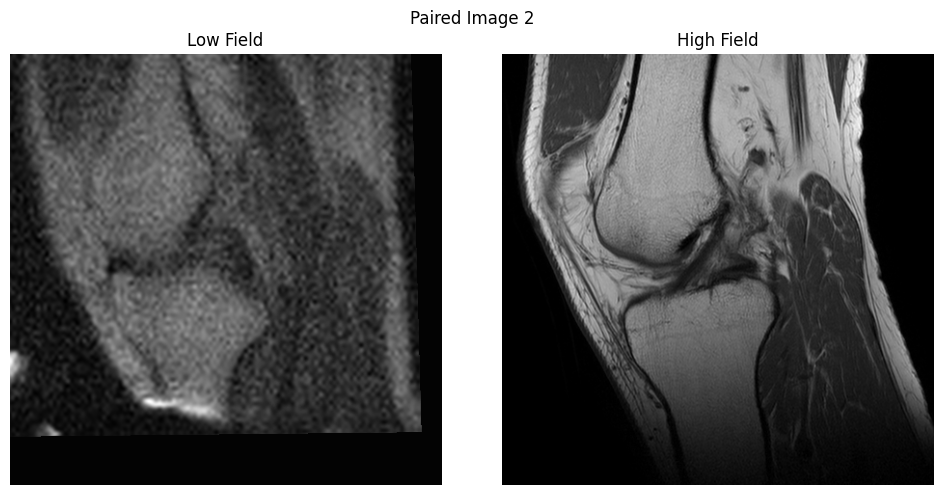

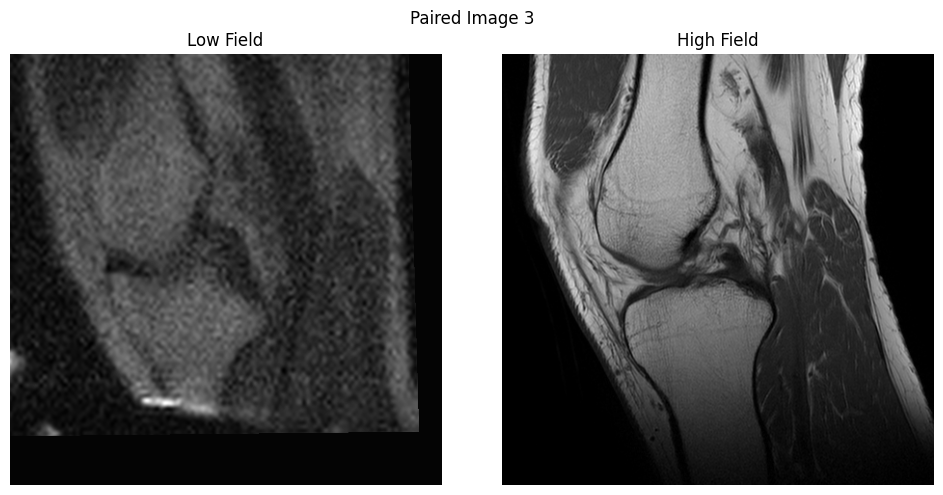

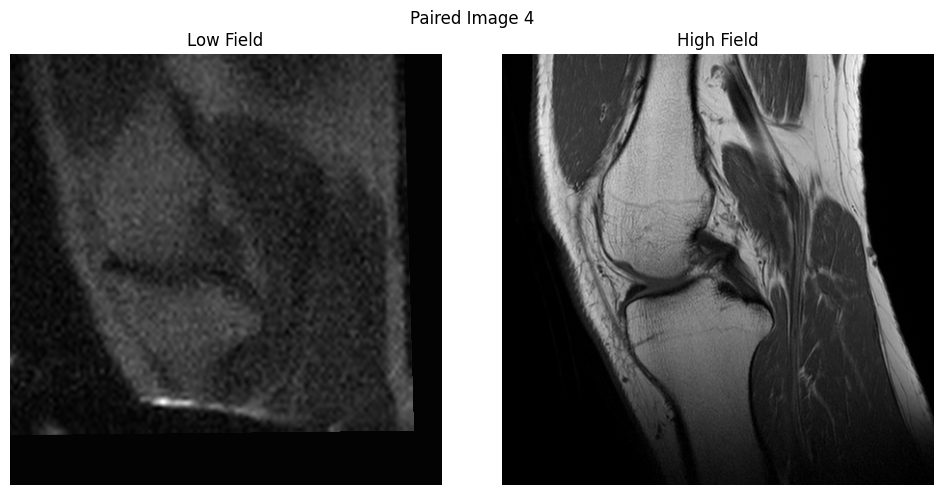

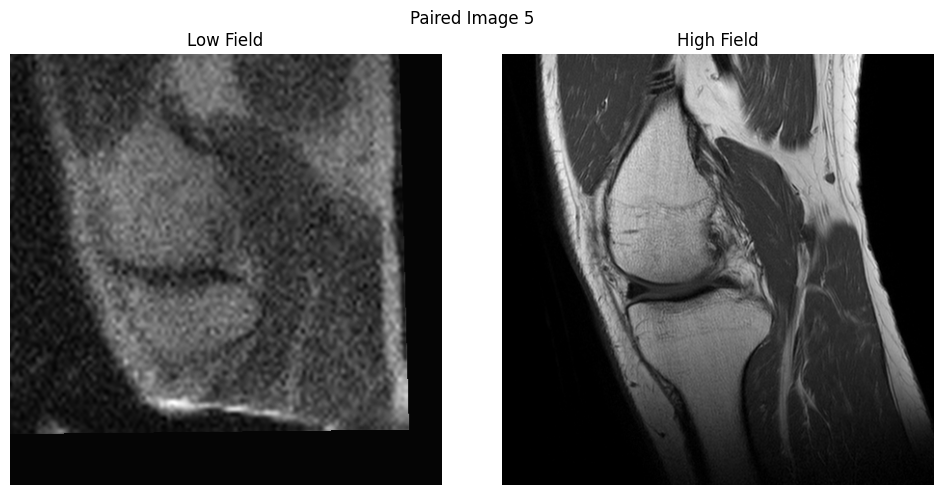

In [8]:
high_field_path = "/content/drive/MyDrive/Ugandan Dataset/Data/train/high_field"
low_field_path = "/content/drive/MyDrive/Ugandan Dataset/Data/train/Low_field"

if not (os.path.isdir(high_field_path) and os.path.isdir(low_field_path)):
    raise Exception("Either High_field or Low_field directory is missing.")

high_images = sorted([f for f in os.listdir(high_field_path) if f.endswith('.png')])
low_images = sorted([f for f in os.listdir(low_field_path) if f.endswith('.png')])

max_pairs = min(5, len(high_images), len(low_images))

for i in range(max_pairs):
    high_img_path = os.path.join(high_field_path, high_images[i])
    low_img_path = os.path.join(low_field_path, low_images[i])

    with Image.open(high_img_path) as high_img, Image.open(low_img_path) as low_img:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(low_img, cmap='gray')
        axes[0].set_title("Low Field")
        axes[0].axis('off')

        axes[1].imshow(high_img, cmap='gray')
        axes[1].set_title("High Field")
        axes[1].axis('off')

        plt.suptitle(f"Paired Image {i + 1}")
        plt.tight_layout()
        plt.show()

### Resize, Random crop and Normalize then Random Jitter

In [14]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [17]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [16]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

### Read data in tensorflow

In [22]:
high_field_path = "/content/drive/MyDrive/Ugandan Dataset/Data/train/high_field"
low_field_path = "/content/drive/MyDrive/Ugandan Dataset/Data/train/Low_field"

high_images = sorted([os.path.join(high_field_path, f) for f in os.listdir(high_field_path) if f.endswith('.png')])
low_images = sorted([os.path.join(low_field_path, f) for f in os.listdir(low_field_path) if f.endswith('.png')])

max_pairs = min(len(high_images), len(low_images))
high_images = high_images[:max_pairs]
low_images = low_images[:max_pairs]

image_pairs = list(zip(low_images, high_images))

IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_and_preprocess(low_path, high_path):
    low_img = tf.io.read_file(low_path)
    low_img = tf.image.decode_png(low_img, channels=3)
    low_img = tf.cast(low_img, tf.float32)

    high_img = tf.io.read_file(high_path)
    high_img = tf.image.decode_png(high_img, channels=3)
    high_img = tf.cast(high_img, tf.float32)

    low_img, high_img = random_jitter(low_img, high_img)
    low_img, high_img = normalize(low_img, high_img)

    return low_img, high_img

def tf_wrapper(low, high):
    return load_and_preprocess(low, high)

In [23]:
path_dataset = tf.data.Dataset.from_tensor_slices((low_images, high_images))
train_dataset = path_dataset.map(lambda x, y: tf_wrapper(x, y),
                                 num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
BATCH_SIZE = 8
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
for low_img_batch, high_img_batch in train_dataset.take(1):
    print("Low-field batch shape:", low_img_batch.shape)
    print("High-field batch shape:", high_img_batch.shape)

Low-field batch shape: (8, 256, 256, 3)
High-field batch shape: (8, 256, 256, 3)


In [26]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = img * 255.0
    return img

# Load image pair
inp = load_image("/content/drive/MyDrive/Ugandan Dataset/Data/train/Low_field/RMP_001_Left_14.png")
re = load_image("/content/drive/MyDrive/Ugandan Dataset/Data/train/high_field/RMP_001_Left_14.png")


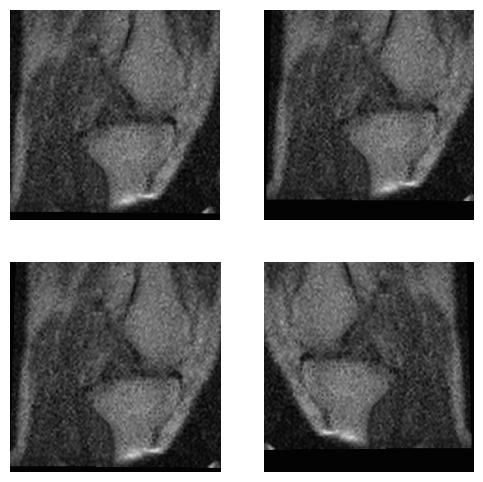

In [27]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [30]:
# For training
low_path_train = "/content/drive/MyDrive/Ugandan Dataset/Data/train/Low_field"
high_path_train = "/content/drive/MyDrive/Ugandan Dataset/Data/train/high_field"

low_path_val = "/content/drive/MyDrive/Ugandan Dataset/Data/val/Low_field"
high_path_val = "/content/drive/MyDrive/Ugandan Dataset/Data/val/high_field"

def load_train_pair(low_path_train, high_path_train):
    low_img = load_image(low_path_train)
    high_img = load_image(high_path_train)
    input_img, real_img = random_jitter(low_img, high_img)
    return input_img, real_img

# For testing
def load_test_pair(low_path_val, high_path_val):
    low_img = load_image(low_path_val)
    high_img = load_image(high_path_val)
    low_img, high_img = resize(low_img, high_img, IMG_HEIGHT, IMG_WIDTH)
    low_img, high_img = normalize(low_img, high_img)
    return low_img, high_img

In [32]:
train_lows = sorted([os.path.join(low_path_train, fname) for fname in os.listdir(low_path_train) if fname.endswith('.png')])
train_highs = sorted([os.path.join(high_path_train, fname) for fname in os.listdir(high_path_train) if fname.endswith('.png')])

val_lows = sorted([os.path.join(low_path_val, fname) for fname in os.listdir(low_path_val) if fname.endswith('.png')])
val_highs = sorted([os.path.join(high_path_val, fname) for fname in os.listdir(high_path_val) if fname.endswith('.png')])


In [34]:
train_ds = tf.data.Dataset.from_tensor_slices((train_lows, train_highs))
train_ds = train_ds.map(load_train_pair, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((val_lows, val_highs))
test_ds = test_ds.map(load_test_pair, num_parallel_calls=tf.data.AUTOTUNE)


### Generator

In [35]:
OUTPUT_CHANNELS = 3

In [36]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [46]:
# Just do this:
inp, _ = next(iter(train_ds))  # inp now has shape (256, 256, 3)

In [47]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [48]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [49]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [50]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

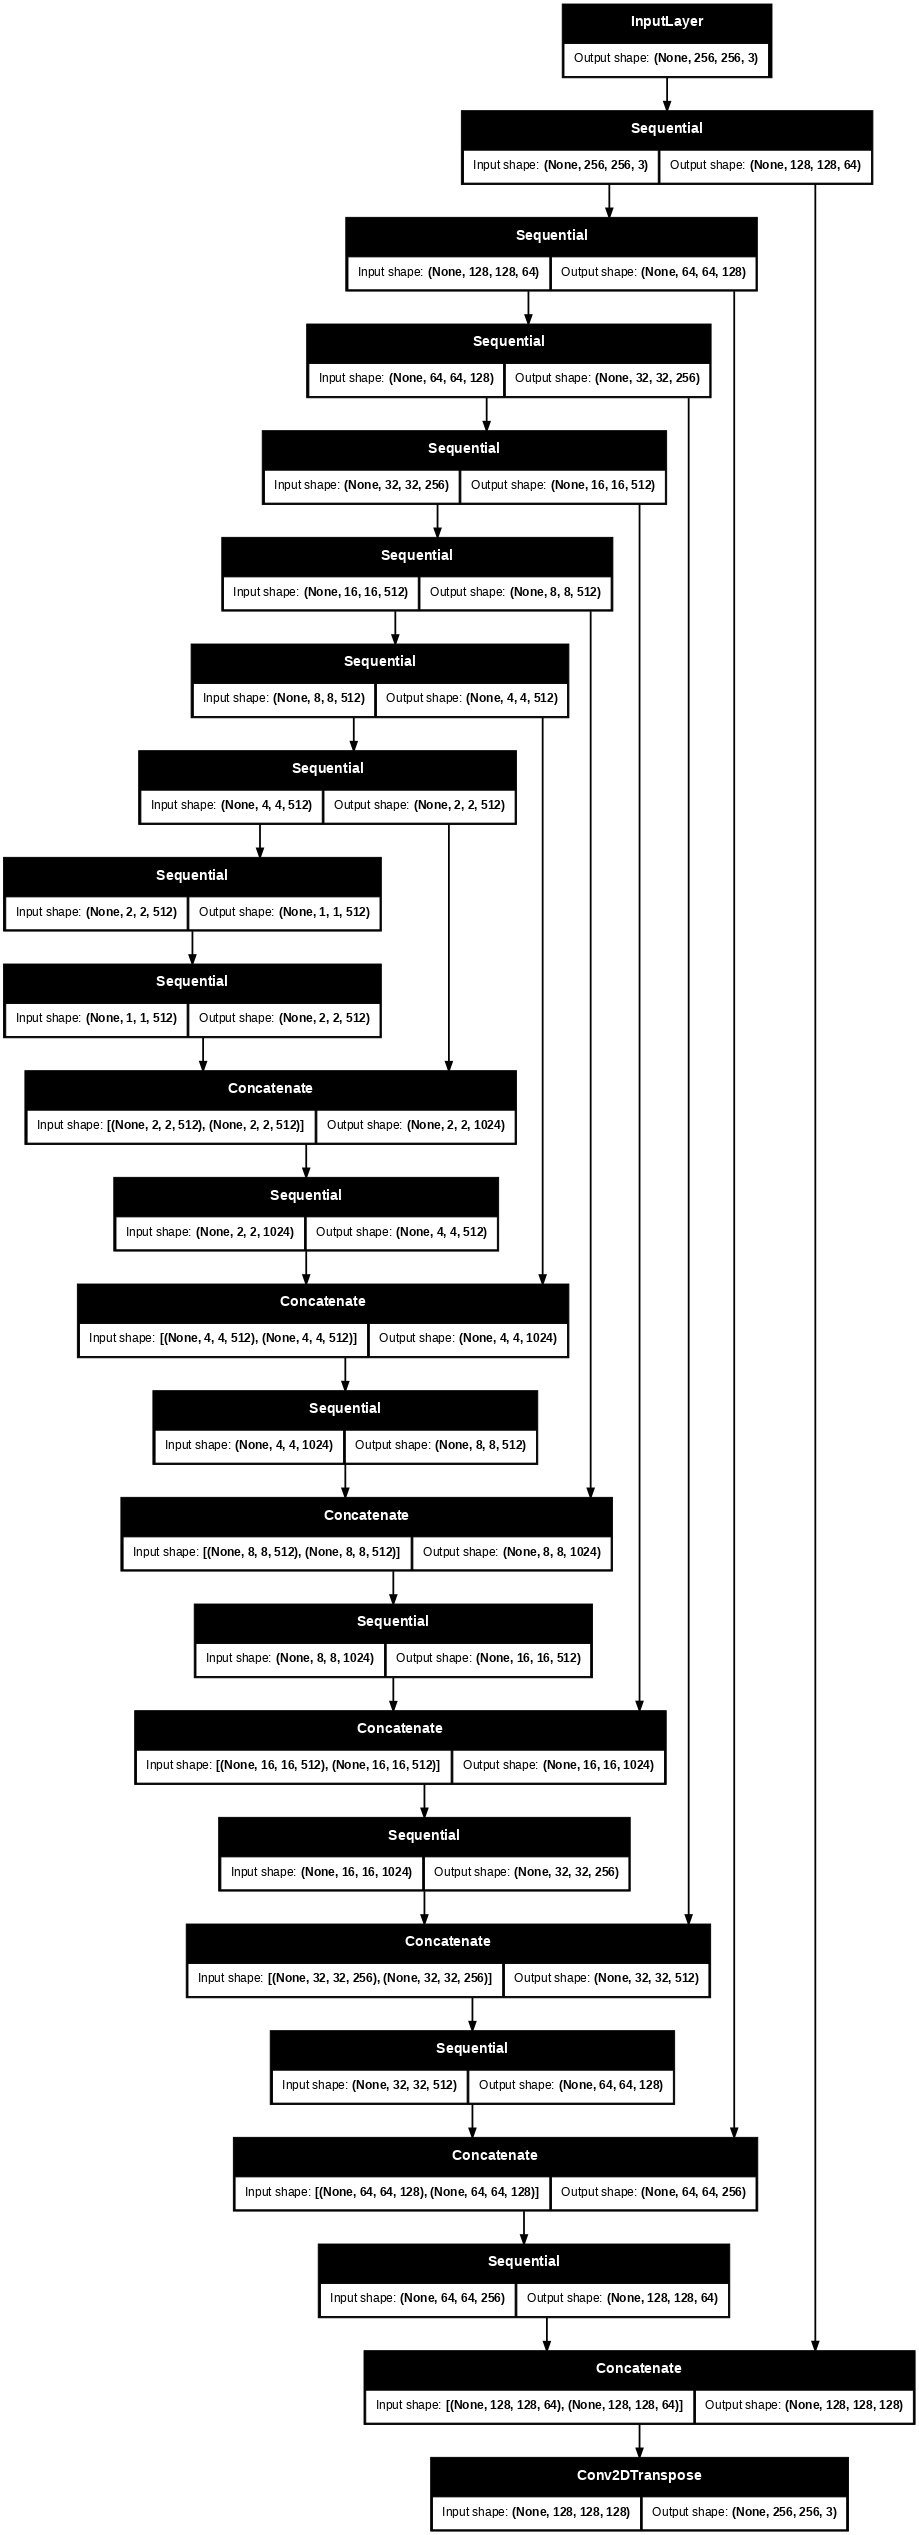

In [51]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

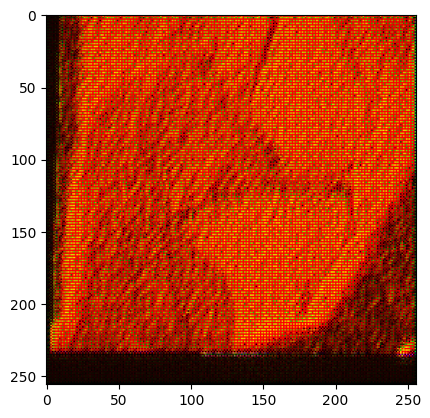

In [52]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

#### Define the generator loss

In [53]:
LAMBDA = 100

In [54]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [55]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Discriminator

In [56]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

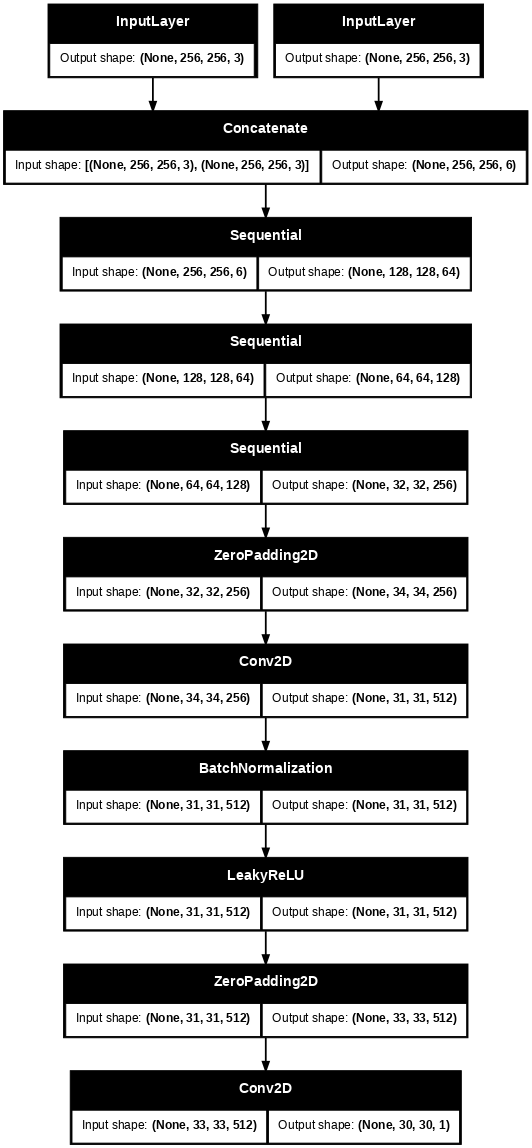

In [57]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

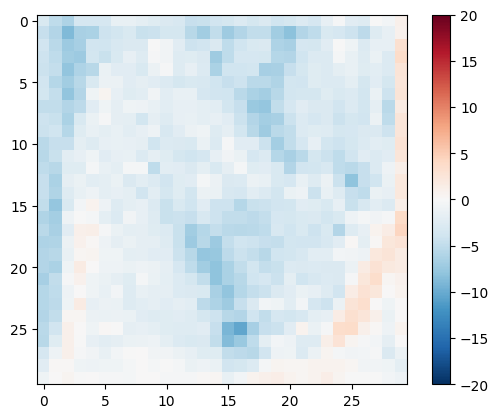

In [58]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

#### Discriminator loss

In [59]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Define the optimizers and a checkpoint-saver

In [60]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Generate images

In [64]:
def generate_images(model, input_img, target_img):
    if len(input_img.shape) == 3:
        input_img = tf.expand_dims(input_img, 0)
    if len(target_img.shape) == 3:
        target_img = tf.expand_dims(target_img, 0)

    prediction = model(input_img, training=True)

    plt.figure(figsize=(15, 5))

    display_list = [input_img[0], target_img[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()


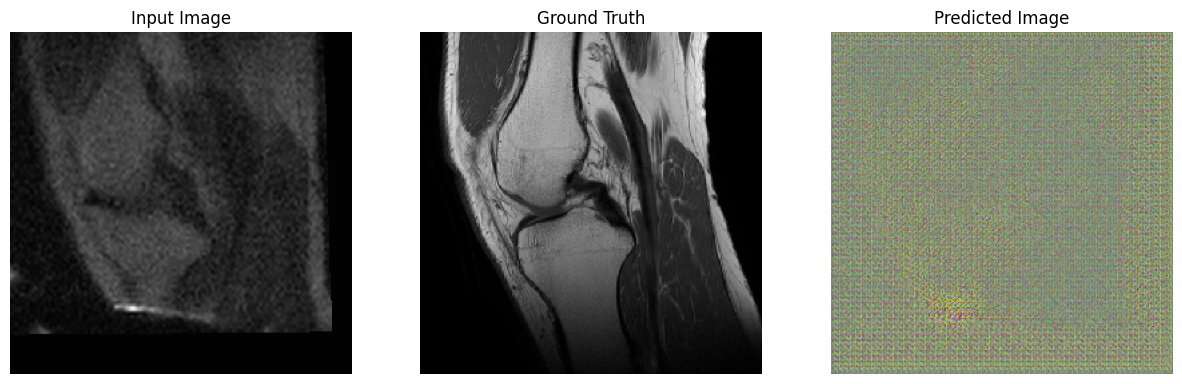

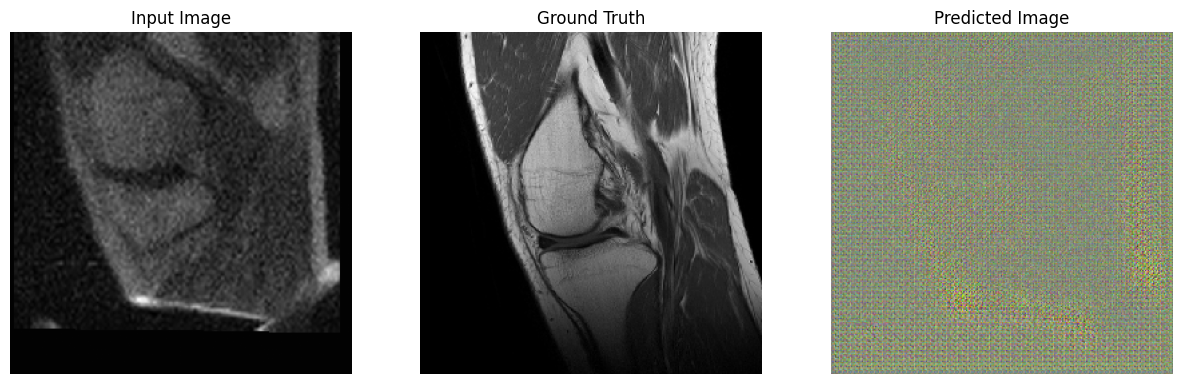

In [67]:
for example_input, example_target in test_ds.take(2):
  generate_images(generator, example_input, example_target)